# Improving NWP Precipitation Forecasting using ML Post-Processing in Morocco 

In support of the Hydrological Sciences Laboratory at GSFC.

This project is an attempt to use machine learning models to improve the traditional physics based weather forecasting models. 

In [227]:
# TODO: Create mask or commit to using locations ... filter df, compare filtered and non filtered RMSE pre and post modeling

In [228]:
#I got these from Claude so maybe double check in the future for better locations/how accurate these ones are

moroccan_locations = {
    "s_sahara": {"Lat": 26.125, "Lon": -13.125},
    "s_sahara_coast": {"Lat": 26.375, "Lon": -12.625},
    "laayoune_area": {"Lat": 26.625, "Lon": -12.375},
    "w_sahara_interior": {"Lat": 26.875, "Lon": -12.125},
    "s_morocco_border": {"Lat": 27.125, "Lon": -11.875},
    "dakhla": {"Lat": 23.875, "Lon": -15.625},
    "dakhla_coast": {"Lat": 24.125, "Lon": -15.375},
    "tarfaya": {"Lat": 27.875, "Lon": -11.375},
    "tan_tan_coast": {"Lat": 28.125, "Lon": -11.125},
    "s_interior": {"Lat": 29.125, "Lon": -9.875},
    "tiznit": {"Lat": 29.375, "Lon": -9.625},
    "agadir_coast": {"Lat": 30.125, "Lon": -9.125},
    "essaouira": {"Lat": 31.125, "Lon": -8.125},
    "el_jadida": {"Lat": 32.125, "Lon": -7.125},
    "casablanca": {"Lat": 33.125, "Lon": -6.125},
    "rabat": {"Lat": 34.125, "Lon": -5.125},
    "tangier": {"Lat": 35.125, "Lon": -4.125},
    "n_coast": {"Lat": 36.125, "Lon": -3.125},
    "n_tip": {"Lat": 37.125, "Lon": -2.125}
}


# Imports

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os

from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse

# Data import & NetCDF conversions

In [230]:
chirps_data_fp = '../data/raw/CHIRPS_1991_2021_MOR.nc'
raw_data_fp = '../data/raw/RAW_CFSv2_1991_2020_MOR.nc'

chirps_cdf=xr.open_dataset(chirps_data_fp)
raw_cdf=xr.open_dataset(raw_data_fp)

data_unprocessed = xr.open_dataset(DATA_FILEPATH, engine='netcdf4')

In [231]:
print(f'chirps file: \n{chirps_cdf}')
print(f'raw data: \n{raw_cdf}')

chirps file: 
<xarray.Dataset>
Dimensions:  (Time: 372, Lat: 74, Lon: 87)
Coordinates:
  * Time     (Time) int32 199101 199102 199103 199104 ... 202110 202111 202112
  * Lat      (Lat) float32 18.88 19.12 19.38 19.62 ... 36.38 36.62 36.88 37.12
  * Lon      (Lon) float32 -19.88 -19.62 -19.38 -19.12 ... 1.125 1.375 1.625
Data variables:
    TP       (Time, Lat, Lon) float32 ...
Attributes:
    creation_date:  Tue Nov  5 18:54:34 EST 2024
    _NCProperties:  version=1|netcdflibversion=4.4.1.1|hdf5libversion=1.8.18
    Conventions:    None
    source_file:    original-file.nc
    title:          NCL Simple Approach to netCDF Creation
raw data: 
<xarray.Dataset>
Dimensions:    (Ensembles: 12, Time: 360, Lead: 6, Lat: 74, Lon: 87)
Coordinates:
  * Ensembles  (Ensembles) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * Time       (Time) int32 199101 199102 199103 199104 ... 202010 202011 202012
  * Lead       (Lead) int32 0 1 2 3 4 5
  * Lat        (Lat) float32 18.88 19.12 19.38 19.62 ... 36.38 36.62 3

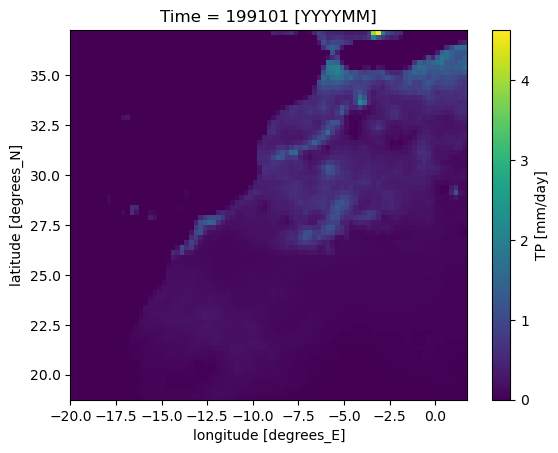

In [232]:
CHIRPS_FP='../data/raw/CHIRPS_1991_2021_MOR.nc'
RAW_FP='../data/raw/RAW_CFSv2_1991_2020_MOR.nc'

chirps_raw=xr.open_dataset(CHIRPS_FP)
model_raw=xr.open_dataset(RAW_FP)

tp_chirps_at_time = chirps_raw.isel(Time=0)

tp_chirps_at_time['TP'].plot()

# Mask

Including a mask to just include the raster within Morocco. This is important to accurately map error.

In [233]:
chirps_df = chirps_raw.to_dataframe().reset_index()
model_df = model_raw.to_dataframe().reset_index()

loc_df = pd.DataFrame(moroccan_locations).T.reset_index()

In [234]:
#TRANSFORMING TO INCLUDE MEAN/MEDIAN TP_PREDICTION
#ALSO CHOOSING A LEAD TO WORK ON

model_by_ensemble = (
    model_df
    .groupby(['Time', 'Lead', 'Lat', 'Lon'])['TP'] #Finding average TP value for all ensembles
    .mean()
    .reset_index()
    .where(model_df['Lead']==3) #Choosing arbitrary lead value
    .dropna()
    .drop(columns=['Lead'])
    .merge(loc_df, on=['Lat', 'Lon'], how='left')
    .rename(columns={'index': 'Location'})
)

print(model_by_ensemble.shape)
model_by_ensemble.head()

(193140, 5)


,Time,Lat,Lon,TP,Location
0,199101.0,18.875,-19.875,0.032430,NaN
1,199101.0,18.875,-19.625,0.033503,NaN
2,199101.0,18.875,-19.375,0.034946,NaN
3,199101.0,18.875,-19.125,0.036389,NaN
4,199101.0,18.875,-18.875,0.037832,NaN


In [235]:
masked_chirps = (
    chirps_df
    .merge(loc_df, on=['Lat', 'Lon'], how='left')
    .rename(columns={'TP':'Predicted_TP', 'index': 'Location'})
)

print(masked_chirps.shape)
masked_chirps.head()

(2394936, 5)


,Time,Lat,Lon,Predicted_TP,Location
0,199101,18.875,-19.875,0.0,NaN
1,199101,18.875,-19.625,0.0,NaN
2,199101,18.875,-19.375,0.0,NaN
3,199101,18.875,-19.125,0.0,NaN
4,199101,18.875,-18.875,0.0,NaN


In [236]:
masked_combined = (
    model_by_ensemble
    .merge(masked_chirps, on=['Time', 'Lat', 'Lon','Location'], how='left')
    .fillna('null') #TODO: FILLING ALL NULL MAY BE AN ISSUE IN FUTURE
)

# Testing

In [237]:
full_df = masked_combined
full_df['Month'] = (full_df['Time']%100).astype(int)

print(full_df.shape)
full_df.head()

(193140, 7)


,Time,Lat,Lon,TP,Location,Predicted_TP,Month
0,199101.0,18.875,-19.875,0.032430,null,0.0,1
1,199101.0,18.875,-19.625,0.033503,null,0.0,1
2,199101.0,18.875,-19.375,0.034946,null,0.0,1
3,199101.0,18.875,-19.125,0.036389,null,0.0,1
4,199101.0,18.875,-18.875,0.037832,null,0.0,1


In [238]:
# REVERSE MASK

df_no_na=full_df

0.2129984282241427


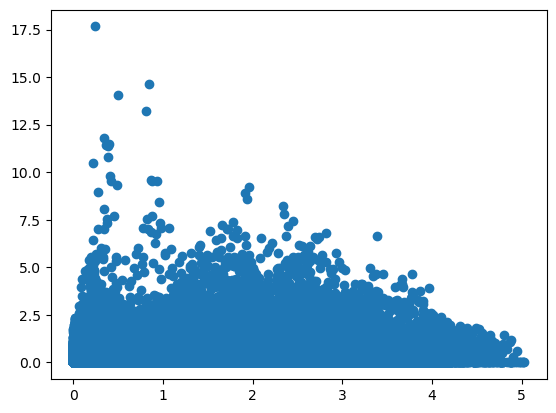

In [239]:
#Correlation between TP and Predicted_TP

print(df_no_na['TP'].corr(df_no_na['Predicted_TP']))
#Correlation seems to be very weak

plt.scatter(df_no_na['TP'], df_no_na['Predicted_TP'])

In [240]:
def error_metrics(df, y_true='TP', y_pred='Predicted_TP', verbose=False):
    y_true=np.array(df[y_true])
    y_pred=np.array(df[y_pred])

    mae_err=mae(y_pred, y_true)
    rmse_err=rmse(y_pred, y_true)

    if verbose:
        print(f"Mean Absolute Error: {mae_err}")
        print(f"Root Mean Squared Error: {rmse_err}")

    return mae_err, rmse_err

In [241]:
error_metrics(df_no_na)

(0.7553222, 1.1755193)

The following was using just the "significant locations" within Morrocco. I did this in an attempt to disregard the portions of the model that are predicting 0's across all time periods/leads/ensembles. The results from the plots of the significant locations show an optimal lead/ensemble combination that produce low amounts of error... I still need to look into how each of these affects the sample size.

# Visualizing Timeseries

In [242]:
print(f"Latitudes available: \n{df_no_na['Lat'].unique()}")
print(f"Longitudes available: \n{df_no_na['Lon'].unique()}")

Latitudes available: 
[18.875 19.125 19.375 19.625 19.875 20.125 20.375 20.625 20.875 21.125
 21.375 21.625 21.875 22.125 22.375 22.625 22.875 23.125 23.375 23.625
 23.875 24.125 24.375 24.625 24.875 25.125 25.375 25.625 25.875 26.125
 26.375 26.625 26.875 27.125 27.375 27.625 27.875 28.125 28.375 28.625
 28.875 29.125 29.375 29.625 29.875 30.125 30.375 30.625 30.875 31.125
 31.375 31.625 31.875 32.125 32.375 32.625 32.875 33.125 33.375 33.625
 33.875 34.125 34.375 34.625 34.875 35.125 35.375 35.625 35.875 36.125
 36.375 36.625 36.875 37.125]
Longitudes available: 
[-19.875 -19.625 -19.375 -19.125 -18.875 -18.625 -18.375 -18.125 -17.875
 -17.625 -17.375 -17.125 -16.875 -16.625 -16.375 -16.125 -15.875 -15.625
 -15.375 -15.125 -14.875 -14.625 -14.375 -14.125 -13.875 -13.625 -13.375
 -13.125 -12.875 -12.625 -12.375 -12.125 -11.875 -11.625 -11.375 -11.125
 -10.875 -10.625 -10.375 -10.125  -9.875  -9.625  -9.375  -9.125  -8.875
  -8.625  -8.375  -8.125  -7.875  -7.625  -7.375  -7.125  -6.87

In [243]:
#Random assortment to just view the timeseries

region = "dakhla"

def plot_ts(region, plot=True):
    tmp=df_no_na[(df_no_na['Lat']==moroccan_locations[region]['Lat']) & (df_no_na['Lon']==moroccan_locations[region]['Lon'])]
    tmp1 = tmp.reset_index(drop=True) \
        .drop(columns=['Time', 'Lat', 'Lon', 'Month'])
    if plot:
        tmp1.plot()
    return tmp1

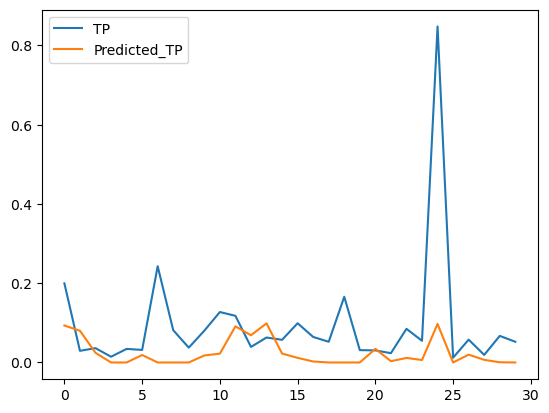

In [244]:
plot_ts(region);

# Getting RMSE of the moroccan location dict

In [245]:
print(rmse(df_no_na['TP'], df_no_na['Predicted_TP']))

print(mae(df_no_na['TP'], df_no_na['Predicted_TP']))

1.1755193
0.7553222


In [246]:
moroccan_locations.keys()

dict_keys(['s_sahara', 's_sahara_coast', 'laayoune_area', 'w_sahara_interior', 's_morocco_border', 'dakhla', 'dakhla_coast', 'tarfaya', 'tan_tan_coast', 's_interior', 'tiznit', 'agadir_coast', 'essaouira', 'el_jadida', 'casablanca', 'rabat', 'tangier', 'n_coast', 'n_tip'])

# Modeling

I'm going to begin modeling now, this will most likely be a case of having to go back and forth between modeling, eda, and feature engineering.

Data isn't linear so I'll start with just a random forest.

Considerations when modeling: 
* Using lat/lon/ensembles, etc... as features. vs only TP as feature
* What model... do I want to/is it necessary to use a NN... I want to start with regression forest.
* Is computational complexity a consideration as well.

Considerations when preprocessing:
* Seasonality... not really present
* Do I care about outliers? -> Forest doesn't handle outlier prediction really well
* Normalization -> Not for trees/forest
* Bring back out the months as a feature -> Worked well
* Can I turn a single feature into many so that I can just use predicted_TP as the sole variable? ... try out SMA/EMA

* Turn discrete data into distributions

In [247]:
#Modeling imports
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split

In [248]:
X_features = ['Lat', 'Lon', 'Predicted_TP', 'Month']

### Splitting the data

I need to use less data, ie create a mask or use the special locations dictionary.

In [249]:
#Renaming for ease of use
df = df_no_na
train_df = df[df['Location'] == 'null'].drop(columns=['Location'])
test_df = df[df['Location'] != 'null'].drop(columns=['Location'])

y_test = test_df['TP'].to_numpy()
X_test = test_df[X_features].to_numpy()

y_train = train_df['TP'].to_numpy()
X_train = train_df[X_features].to_numpy()

In [250]:
train_df

,Time,Lat,Lon,TP,Predicted_TP,Month
0,199101.0,18.875,-19.875,0.032430,0.0,1
1,199101.0,18.875,-19.625,0.033503,0.0,1
2,199101.0,18.875,-19.375,0.034946,0.0,1
3,199101.0,18.875,-19.125,0.036389,0.0,1
4,199101.0,18.875,-18.875,0.037832,0.0,1
...,...,...,...,...,...,...
193135,199306.0,37.125,0.625,2.103576,0.0,6
193136,199306.0,37.125,0.875,2.239305,0.0,6
193137,199306.0,37.125,1.125,2.419549,0.0,6
193138,199306.0,37.125,1.375,2.614631,0.0,6


These models are taking 30+ minutes to train, but they are not optimized for efficiency. If this is a direction we are wanting to continue in, there are ways to make this much faster, and also not processing on a laptop speeds things up as well. 

## Random Forest Regressor

In [251]:
#Default DTR massively overfits
#save this next time

dtr_multi_var = RandomForestRegressor()
dtr_multi_var.fit(X_train, y_train)
preds = dtr_multi_var.predict(X_test)
rmse(y_test, preds)


0.163252639756439

## Neural Network

<BarContainer object of 4 artists>

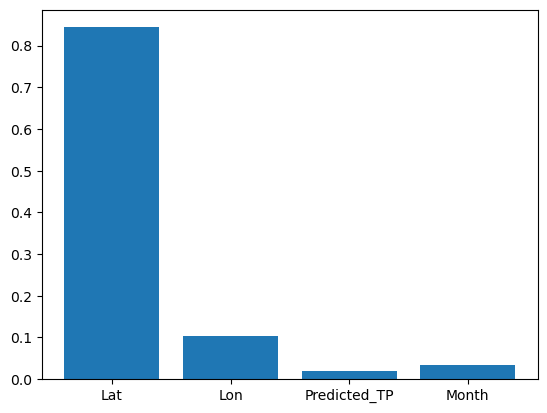

In [252]:
plt.bar(X_features, dtr_multi_var.feature_importances_)

Notes:

Model(hyperparams) :: rmse for dict moroccan_locations

RandomForestRegressor(min_samples_split=100) :: 0.0434605942144219

(Added the month feature 12/13)

RandomForestRegressor(min_samples_split=250) :: 0.08197658497343975

RandomForestRegressor(min_samples_split=100) :: 0.03327709130977539

Changed training proportion: 80% -> 50% (Just to speed up experimentation)

In [253]:
moroccan_locations.keys()

dict_keys(['s_sahara', 's_sahara_coast', 'laayoune_area', 'w_sahara_interior', 's_morocco_border', 'dakhla', 'dakhla_coast', 'tarfaya', 'tan_tan_coast', 's_interior', 'tiznit', 'agadir_coast', 'essaouira', 'el_jadida', 'casablanca', 'rabat', 'tangier', 'n_coast', 'n_tip'])

In [254]:
#Can make better by choosing model in the def args
def plot_region_ts(df, region):
    tmp=df[(df['Lat']==moroccan_locations[region]['Lat']) & (df['Lon']==moroccan_locations[region]['Lon'])]
    tmp=tmp.dropna()
    tmp_X = tmp.loc[:, X_features].to_numpy()

    tmp['rfr_100'] = dtr_multi_var.predict(tmp_X)
    #tmp['rfr_250'] = dtr_multi_var.predict(tmp_X)

    tmp.loc[:, ['rfr_100', 'TP', 'Predicted_TP']].plot()

    return tmp, tmp_X

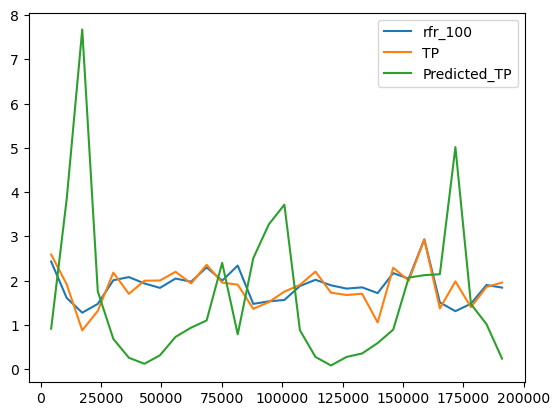

In [255]:
region = "essaouira"
ensemble_no = 5
lead_no = 5

plot_region_ts(full_df, region);

# Map

In [256]:
import folium
from folium.plugins import HeatMap

def show_heatmap(predicted_column_name, df = full_df):

    lat_median = full_df['Lat'].mean()
    lon_median = full_df['Lon'].mean()

    map_center = [lat_median, lon_median]
    m = folium.Map(location=map_center, zoom_start = 6, control_scale=True)
    full_df['rmse'] = (abs(full_df['TP'] - full_df[predicted_column_name])) * 100
    map_rmse_df = full_df.groupby(['Lat', 'Lon'])['rmse'].sum().reset_index()
    map_rmse_df = map_rmse_df.values.tolist()
    HeatMap(map_rmse_df, radius=10, blur=5).add_to(m)

    return m

In [257]:
show_heatmap('Predicted_TP')

In [258]:
from xgboost import XGBRegressor

In [259]:
xg_model = XGBRegressor()
xg_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
xg_preds = xg_model.predict(X_test)
print(rmse(y_test, xg_preds))

[0]	validation_0-rmse:0.70964	validation_1-rmse:0.80181
[1]	validation_0-rmse:0.53535	validation_1-rmse:0.60866
[2]	validation_0-rmse:0.42004	validation_1-rmse:0.48183
[3]	validation_0-rmse:0.34731	validation_1-rmse:0.40551
[4]	validation_0-rmse:0.30255	validation_1-rmse:0.35559
[5]	validation_0-rmse:0.27123	validation_1-rmse:0.32425
[6]	validation_0-rmse:0.25369	validation_1-rmse:0.30630
[7]	validation_0-rmse:0.24147	validation_1-rmse:0.29578
[8]	validation_0-rmse:0.23415	validation_1-rmse:0.28386
[9]	validation_0-rmse:0.22916	validation_1-rmse:0.27961
[10]	validation_0-rmse:0.22497	validation_1-rmse:0.27326
[11]	validation_0-rmse:0.22167	validation_1-rmse:0.26999
[12]	validation_0-rmse:0.21940	validation_1-rmse:0.26612
[13]	validation_0-rmse:0.21681	validation_1-rmse:0.26096
[14]	validation_0-rmse:0.21484	validation_1-rmse:0.25559
[15]	validation_0-rmse:0.21377	validation_1-rmse:0.25377
[16]	validation_0-rmse:0.21260	validation_1-rmse:0.24867
[17]	validation_0-rmse:0.20985	validation

In [260]:
full_df['xg_boost'] = xg_model.predict(full_df[X_features])

In [261]:
show_heatmap('xg_boost')